In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import os
import pandas as pd
import cv2

In [3]:
# --- Configuration ---
preprocessed_path = r'D:\FUCK!!\Pattern\Project\notebooks\preprocessed_RGB_images' # Make sure this path is correct
input_shape = (224, 224, 3)  # Standard VGG16 RGB input
batch_size = 64
num_epochs = 20 # Set a higher number of epochs, EarlyStopping will handle the actual stop

In [15]:
# --- Data Generators ---
# Training data generator with augmentation
train_datagen = ImageDataGenerator(rescale=1./255)

print("Setting up Training Generator...")
train_generator = train_datagen.flow_from_directory(
    os.path.join(preprocessed_path, 'train'),
    target_size=input_shape[:2], # Use (224, 224)
    batch_size=batch_size,
    class_mode='sparse',         # Use sparse for sparse_categorical_crossentropy
    color_mode='rgb',
    shuffle=True             # Ensure images are loaded as RGB
)
print(f"Found {train_generator.samples} images belonging to {train_generator.num_classes} classes in training set.")

print("\nSetting up Validation Generator...")
val_generator = train_datagen.flow_from_directory(
    os.path.join(preprocessed_path, 'val'),
    target_size=input_shape[:2], # Use (224, 224)
    batch_size=batch_size,
    class_mode='sparse',         # Use sparse for sparse_categorical_crossentropy
    color_mode='rgb',            # Ensure images are loaded as RGB
    shuffle=False                # No need to shuffle validation data
)
print(f"Found {val_generator.samples} images belonging to {val_generator.num_classes} classes in validation set.")


Setting up Training Generator...
Found 17485 images belonging to 10 classes.
Found 17485 images belonging to 10 classes in training set.

Setting up Validation Generator...
Found 469 images belonging to 10 classes.
Found 469 images belonging to 10 classes in validation set.


In [16]:
# Get the number of classes from the generator
num_classes = train_generator.num_classes
if num_classes != val_generator.num_classes:
    print("Warning: Training and validation sets have different numbers of classes!")


In [17]:
# --- Build VGG16 Model ---
print("\nBuilding VGG16 model...")
# Load VGG16 base pre-trained on ImageNet, exclude top classification layer
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# 2) Freeze early blocks, fine-tune later ones
for layer in base_model.layers[:10]:
    layer.trainable = False
for layer in base_model.layers[10:]:
    layer.trainable = True
print(f"VGG16 base model loaded. Trainable: {base_model.trainable}")

# Create the new model head
vgg16_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(name='global_avg_pool'),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu', name='fc1'),
    layers.Dropout(0.5, name='dropout_1'), # Dropout for regularization
    layers.BatchNormalization(),
    layers.Dense(num_classes, activation='softmax', name='predictions') # Output layer
], name="VGG16_Transfer_Learning")

# --- Compile Model ---
# Use Adam optimizer with a specific, smaller learning rate
optimizer = Adam(learning_rate=0.0001) # 0.0001 learning rate

vgg16_model.compile(optimizer=optimizer,
                    loss='sparse_categorical_crossentropy', # Use sparse CE with class_mode='sparse'
                    metrics=['accuracy'])

print("\nModel Summary:")
vgg16_model.summary()


Building VGG16 model...
VGG16 base model loaded. Trainable: True

Model Summary:


Model: "VGG16_Transfer_Learning"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,986,570 (57.17 MB)

 Trainable params: 13,249,034 (50.54 MB)

 Non-trainable params: 1,737,536 (6.63 MB)

In [19]:
# --- Define Callbacks ---
# Early stopping to prevent overfitting and stop training when val_loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True # Restore model weights from the epoch with the best val_loss
)

# Model checkpoint to save the best model found during training
model_checkpoint = ModelCheckpoint(
    filepath='best_vgg16_model.keras', # File path to save the model
    monitor='val_loss',
    save_best_only=True, # Only save a model if `val_loss` has improved
    verbose=1
)

reduce = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=3, 
    min_lr=1e-7, 
    verbose=1
    )

In [20]:
# --- Train the Model (Head Only) ---
print(f"\nStarting training for up to {num_epochs} epochs (head only)...")
history = vgg16_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size, # Ensure steps cover the dataset
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size, # Ensure steps cover the dataset
    epochs=num_epochs,
    callbacks=[early_stopping, model_checkpoint, reduce] # Add the callbacks
)

print("\nTraining finished.")


Starting training for up to 20 epochs (head only)...
Epoch 1/20


c:\Users\omarn\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5269 - loss: 1.4064
Epoch 1: val_loss improved from inf to 0.97759, saving model to best_vgg16_model.keras
273/273 ━━━━━━━━━━━━━━━━━━━━ 1605s 6s/step - accuracy: 0.5274 - loss: 1.4046 - val_accuracy: 0.6719 - val_loss: 0.9776 - learning_rate: 1.0000e-04
Epoch 2/20
  1/273 ━━━━━━━━━━━━━━━━━━━━ 25:43 6s/step - accuracy: 0.8281 - loss: 0.5037

c:\Users\omarn\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 0.97759
273/273 ━━━━━━━━━━━━━━━━━━━━ 26s 76ms/step - accuracy: 0.8281 - loss: 0.5037 - val_accuracy: 0.6696 - val_loss: 0.9844 - learning_rate: 1.0000e-04
Epoch 3/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9019 - loss: 0.2870
Epoch 3: val_loss improved from 0.97759 to 0.67022, saving model to best_vgg16_model.keras
273/273 ━━━━━━━━━━━━━━━━━━━━ 1599s 6s/step - accuracy: 0.9020 - loss: 0.2868 - val_accuracy: 0.8281 - val_loss: 0.6702 - learning_rate: 1.0000e-04
Epoch 4/20
  1/273 ━━━━━━━━━━━━━━━━━━━━ 26:41 6s/step - accuracy: 0.9688 - loss: 0.1171
Epoch 4: val_loss improved from 0.67022 to 0.66586, saving model to best_vgg16_model.keras
273/273 ━━━━━━━━━━━━━━━━━━━━ 28s 83ms/step - accuracy: 0.9688 - loss: 0.1171 - val_accuracy: 0.8304 - val_loss: 0.6659 - learning_rate: 1.0000e-04
Epoch 5/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9763 - loss: 0.0870
Epoch 5: val_loss did not improve from 0.66586
273/273 ━━━━━━━━━━━━━━━━

In [24]:
from tensorflow.keras.models import load_model
model = load_model(r'D:\FUCK!!\Pattern\Project\Models\best_vgg16_model.keras')

In [34]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix

# 1) Prepare a “pure” test generator (no augmentation, only the same preprocessing)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_gen = test_datagen.flow_from_directory(
    directory=r'D:\FUCK!!\Pattern\Project\notebooks\preprocessed_RGB_images\val',    # point this to your test‐folder 
    target_size=input_shape[:2],           # e.g. (224, 224)
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False                           # important! so labels/preds align
)

Found 469 images belonging to 10 classes.


In [35]:
# 0) Clear any old graphs / functions
tf.keras.backend.clear_session()

# 1) Reload your .keras model
model = load_model(r'D:\FUCK!!\Pattern\Project\Models\best_vgg16_model.keras')

# 2) Re-compile it with the correct loss and metrics, running eagerly
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    run_eagerly=True    # ← this disables the tf.function wrapping
)

# 3) Now evaluate on your test generator (no need to pass steps)
loss, acc = model.evaluate(test_gen, verbose=1)
print(f"\nTest loss: {loss:.4f} — Test accuracy: {acc:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.6028 - loss: 48.6434

Test loss: 56.9285 — Test accuracy: 0.5565


In [38]:
# 3) (Optional) Get per‐class metrics
#    - Predict class probabilities
steps = int(np.ceil(test_gen.samples / batch_size))
pred_probs = model.predict(
    test_gen,
    steps = steps,
    verbose=1
)
#    - Turn them into predicted class indices
pred_idxs = np.argmax(pred_probs, axis=1)
true_idxs = test_gen.classes
labels   = list(test_gen.class_indices.keys())

#    - Classification report
print("\nClassification Report:\n")
print(classification_report(true_idxs, pred_idxs, target_names=labels))

#    - Confusion matrix
print("\nConfusion Matrix:\n")
print(confusion_matrix(true_idxs, pred_idxs))

8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step

Classification Report:

                                  precision    recall  f1-score   support

         Achaemenid architecture       0.69      0.65      0.67        96
American Foursquare architecture       0.50      0.98      0.66        61
        American craftsman style       0.71      0.15      0.24        34
   Ancient Egyptian architecture       0.57      0.13      0.22        30
           Art Deco architecture       0.85      0.28      0.42        40
        Art Nouveau architecture       0.29      0.67      0.41        33
            Baroque architecture       0.45      0.79      0.57        43
            Bauhaus architecture       0.76      0.91      0.83        45
         Beaux-Arts architecture       0.83      0.11      0.19        47
          Byzantine architecture       0.81      0.42      0.56        40

                        accuracy                           0.56       469
                       macro avg       0.65     

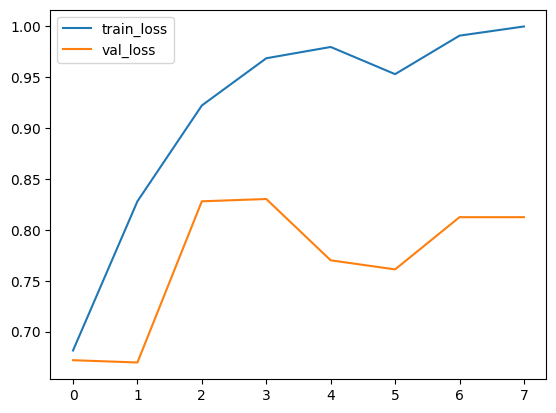

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_loss')
plt.plot(history.history['val_accuracy'], label='val_loss')
plt.legend(); plt.show()

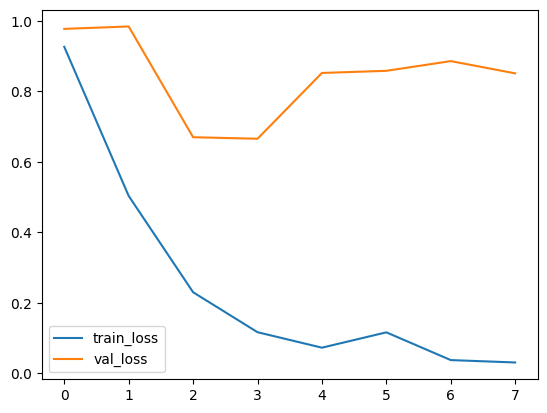

In [21]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the output for multiclass ROC AUC
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
rf_probs = rf.predict_proba(X_test_scaled)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i, class_name in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], rf_probs[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], rf_probs[:, i])

plt.figure(figsize=(8, 6))
for i, class_name in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_name} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RandomForest')
plt.legend()
plt.show()